# Project summary
This data analysis project was carried out as part of an experiment to determine the influence of training on a data collector's ability to identify relevant information while gathering data.

\
Specifically, this project made use of eye tracking data, and sought to yield insights on how the differences in training affects each participants focus on specific regions (called _AOIs_, meaning _areas of interest_) of the images.
\
## Methodology
Two important concepts need to be defined; namely _saccades_ and _fixations_:

1.   **Saccades:** A saccade is a rapid eye movement between two focus points.
2.   **Fixations:**: A fixation is a focus on a single region on an image for a significant amount of time.

The difference between saccades and fixations ultimately comes down to their _speed_, or velocity. For this analysis, following research from [a published and well-regarded paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC8012014/), we defined saccades based on _angular velocity_ (ie. the angle the participants' pupil travels when moving from one focus point to another) measured in degrees/second.

Following guidelines from [another paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC7608620/), we were able to convert the degrees/second velocity measurements used to define saccades and fixations into pixel displacement/second. We then used these measurements to determine what constituted a fixation and a saccade in our data.

One of reasons why we are computing this using the raw data eye movement data(x,y,time) as oppose to the fixation and saccade data from the eyetracking software is that we can have finer control over the analysis. With this approach we can implement functions that allow us to track participant's eye movements(i.e fixations and saccades), within and across our custom defined AOIs in each image, which is imposible to do with just the fixation data from the eyetracking software.In many ways our approach offers a more transparent and controllable method of analysis as opposed to the black box analysis from most premium eyectraking software.

The actual figures used in these calculations may be changed by modifying the relevant variables in the "Configuration" section.

\
### Analysis
After establishing the above definitions, we then counted the fixations and saccades of each participant, of each image, across the three types of areas of interests (AOIs) present in the data:

*   Diagnostic attributes of the primary entity (Black AOI)
*   Non-diagnostic attributes of the primary entity (Green AOI)
*   Secondary entities present in the image (Red AOI)

We also kept track of the total time spent fixating/saccading in each of these three regions. Afterwards, we performed an ANOVA and post-hoc analysis on these features, and present the results in a table at the end of this notebook.









# Connecting to Google Drive




# Install and import the necessary packages

In [1]:
%pip install pingouin statsmodels


[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:


import os
import copy
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from itertools import combinations
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from shapely import Polygon, MultiPoint, Point
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.libqsturng import psturng
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Configuration
Here, you can tweak the variables of the experiment

In [3]:
WORKING_DIRECTORY = '/'
BOX_COORDINATES = "Data/Boxes"
DATA_DIRECTORY = "/Data"
ALL_AOI_RECTS = []
MAX_ALLOWABLE_DISPLACEMENT = 50   # in pixels

MIN_FIXATION_DURATION = 200/1000   # Salvucci, D. D. & Goldberg, J. H. Identifying fixations and saccades in eye-tracking protocols. In Proceedings of the 2000 Symposium on Eye Tracking Research & Applications 71-78 (ACM, 2000).
DEG_CONVERSION_PX = 1/0.05        # https://pmc.ncbi.nlm.nih.gov/articles/PMC7608620/
MIN_SACCADE_TIME = MAX_ALLOWABLE_DISPLACEMENT/((240*DEG_CONVERSION_PX)/1) #using a minimum saccade velocity of 240 deg/second. source:https://pmc.ncbi.nlm.nih.gov/articles/PMC7608620/
NUMBER_OF_PARTICIPANTS,NUMBER_OF_IMAGES = 20,20

#os.chdir(WORKING_DIRECTORY)

# Helper functions
These are simple functions to aid us in parsing the data into more useful data structures, as well as perform rudimentary analyses.

In [4]:
def analyze_eye_movementsv2(MIN_FIXATION_DURATION, data,boxes, img_no):
    """
    Analyze eye movements to count saccades, fixations, and calculate fixation metrics.

    Args:
        MIN_FIXATION_DURATION (float): Minimum duration (ms) for a fixation to be valid.
        data (dict): A dictionary with 'time', 'x', and 'y' keys containing lists of corresponding values.

    Returns:
        dict: A dictionary with counts of saccades, fixatiom data for each class, total fixation time, and .
    """
    velocity_threshold = MAX_ALLOWABLE_DISPLACEMENT / MIN_SACCADE_TIME
    saccade_count = 0
    fixation_data = {
        "black":{"fixation_count":0, "fixation_duration":0},
        "green":{"fixation_count":0, "fixation_duration":0},
        "red": {"fixation_count":0, "fixation_duration":0},
        "Not_AOI": {"fixation_count":0, "fixation_duration":0}
    }
    saccade_data ={
        "black":{"saccade_count":0,"saccade_duration":0,"saccade_length_px":0},
        "green":{"saccade_count":0,"saccade_duration":0,"saccade_length_px":0},
        "red": {"saccade_count":0,"saccade_duration":0,"saccade_length_px":0},
        "Not_AOI": {"saccade_count":0,"saccade_duration":0,"saccade_length_px":0}
    }
    visitation_time = {
                'black':  0,
                'green':0,
                'red': 0,
                'Not_AOI': 0
                }

    # Extract data
    time = np.array(data['Time'])
    x = np.array(data['X'])
    y = np.array(data['Y'])


    # Identify fixations
    fixations = []
    average_fixation_points = []
    total_fixation_time = 0
    current_fixation = [0]
    #find first fixation
    current_aoi = find_current_fixation_box((x[0],y[0]),boxes)


    for i in range(1,len(x)):
      point_AOI = find_current_fixation_box((x[i],y[i]),boxes)#checks the AOI of the current point
      if point_AOI == current_aoi:
        current_fixation.append(i)

      else:
      # exits aoi, fixation ends and a saccade(transition bwtween AOI) begins
        if current_fixation:
          fixation_duration = time[current_fixation[-1]] - time[current_fixation[0]]
          if fixation_duration >= MIN_FIXATION_DURATION:
            fixations.append(current_fixation)
            total_fixation_time += fixation_duration
            fixation_data[current_aoi]["fixation_count"] += 1
            fixation_data[current_aoi]["fixation_duration"] += fixation_duration
            visitation_time[current_aoi] += fixation_duration
            #calculate saccade metrics
            saccade_time = time[i] - time[current_fixation [-1]]
            saccade_data[point_AOI]["saccade_count"] += 1
            saccade_data[point_AOI]["saccade_length_px"] += np.sqrt((x[i]-x[current_fixation[-1]])**2 + (y[i]-y[current_fixation[-1]])**2)
            saccade_data[point_AOI]["saccade_duration"] += saccade_time
            visitation_time[point_AOI] += saccade_time
            current_aoi = point_AOI
            current_fixation = [i]


    # Handle last fixation if the loop ends on a fixation
    if current_fixation:
      fixation_duration = time[current_fixation[-1]] - time[current_fixation[0]]
      if fixation_duration >= MIN_FIXATION_DURATION:
        fixations.append(current_fixation)
        total_fixation_time += fixation_duration
        fixation_data[current_aoi]["fixation_count"] += 1
        fixation_data[current_aoi]["fixation_duration"] +=fixation_duration
        visitation_time[current_aoi] += fixation_duration

    fixation_count = len(fixations)

    return {
        "IMG_ID":img_no,
        'saccade_count': saccade_count,
        'total_fixation_count': fixation_count,
        'total_fixation_time': total_fixation_time,
        'AOI_fixation_data': fixation_data,
        'AOI_saccade_data':saccade_data,
        "AOI_visitation_time":visitation_time
    }


In [5]:
def create_box_geometry(coords):
  #takes in a dictionary of the different classes of AOI and returns polygon objects
  #e.g coords = {"black":[((x1,y1),(x2,y2),(x3,y3),(x4,y4))], "green":[((x1,y1),(x2,y2),(x3,y3),(x4,y4))]}
  boxes = {}
  for key in coords.keys():
    geoms = []
    for blob in coords[key]:
      geom = Polygon(blob)
      geoms.append(geom)
    boxes[key]= copy.deepcopy(geoms)
  return boxes


def get_full_coords(data):
  #uses the coordinates of the diagonals of the rectangle to calculate the co0rdinantes of the unknown points
  coords = []
  for i, record in data.iterrows():
    x1,y1 = record["X1"],record["Y1"]
    x4,y4 = record["X2"],record["Y2"]
    y2 =y1
    x2=x4
    y3=y4
    x3=x1
    coords.append(((x1,y1),(x2,y2),(x3,y3),(x4,y4)))
  return coords

def join_dataframes(dfs, suffixes):
    """
    Joins multiple DataFrames on 'Participant_id' and 'Image_id' with suffixes.

    Parameters:
    - dfs (list of pd.DataFrame): List of DataFrames to join.
    - suffixes (list of str): List of suffixes corresponding to each DataFrame.

    Returns:
    - pd.DataFrame: The joined DataFrame.
    """
    if len(dfs) != len(suffixes):
        raise ValueError("Number of DataFrames and suffixes must match.")

    # Start with the first DataFrame
    merged_df = dfs[0]

    # Iterate over the remaining DataFrames and suffixes
    for i in range(1, len(dfs)):
        merged_df = merged_df.merge(
            dfs[i],
            on=["Participant_id", "image_id"],
            suffixes=("", suffixes[i])
        )

    # Rename columns for the first DataFrame with its suffix
    for col in merged_df.columns:
        if col not in ["Participant_id", "image_id"]:
            if col in dfs[0].columns:
                merged_df.rename(columns={col: f"{col}{suffixes[0]}"}, inplace=True)

    return merged_df


def calculate_saccade_mean(indices, x, y):
  #calculate the mean position of the eye between saccades
  mean_x = np.mean(x[indices])
  mean_y = np.mean(y[indices])
  return mean_x, mean_y


def find_current_fixation_box(point,boxes):
  #takes in the polygons and the current position of the subjects gaze
  # iterating through all boxes in all AOI classses per picture
  pt = Point(point)
  current_box_index = None #
  current_box_class = None
  for key in boxes.keys():
    for box in boxes[key]:
      if pt.within(box):
        current_box_class = key
        current_box_index = boxes[key].index(box)
        return  current_box_class
      else:
        continue
  if current_box_class == None:
     return "Not_AOI"


def analyze_eye_movements(MAX_ALLOWABLE_DISPLACEMENT, MIN_SACCADE_TIME, MIN_FIXATION_DURATION, data,boxes, img_no):
    """
    Analyze eye movements to count saccades, fixations, and calculate fixation metrics.

    Args:
        MAX_ALLOWABLE_DISPLACEMENT (float): Maximum displacement (pixels) for saccade velocity calculation.
        MIN_SACCADE_TIME (float): Minimum duration (ms) for a saccade.
        MIN_FIXATION_DURATION (float): Minimum duration (ms) for a fixation to be valid.
        data (dict): A dictionary with 'time', 'x', and 'y' keys containing lists of corresponding values.

    Returns:
        dict: A dictionary with counts of saccades, fixatiom data for each class, total fixation time, and .
    """
    velocity_threshold = MAX_ALLOWABLE_DISPLACEMENT / MIN_SACCADE_TIME
    saccade_count = 0
    fixation_data = {
        "black":{"fixation_count":0, "fixation_duration":0},
        "green":{"fixation_count":0, "fixation_duration":0},
        "red": {"fixation_count":0, "fixation_duration":0},
        "Not_AOI": {"fixation_count":0, "fixation_duration":0}
    }
    saccade_data ={
        "black":{"saccade_count":0,"saccade_duration":0,"saccade_length_px":0},
        "green":{"saccade_count":0,"saccade_duration":0,"saccade_length_px":0},
        "red": {"saccade_count":0,"saccade_duration":0,"saccade_length_px":0},
        "Not_AOI": {"saccade_count":0,"saccade_duration":0,"saccade_length_px":0}
    }
    visitation_time = {
                'black':  0,
                'green':0,
                'red': 0,
                'Not_AOI': 0
                }

    # Extract data
    time = np.array(data['Time'])
    x = np.array(data['X'])
    y = np.array(data['Y'])

    # Calculate velocity
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(time)
    velocity = np.sqrt(dx**2 + dy**2) / dt


    # Identify saccades
    saccades = velocity > velocity_threshold
    saccade_count = np.sum(saccades)

    #identify the mean positions of the saccade
    for i in range(len(saccades)):
        if saccades[i]:
            mean_x, mean_y = calculate_saccade_mean([i,i+1], x, y)
            saccade_AOI = find_current_fixation_box((mean_x,mean_y),boxes)
            saccade_data[saccade_AOI]["saccade_count"] += 1
            saccade_data[saccade_AOI]["saccade_duration"] += time[i+1] - time[i]
            saccade_data[saccade_AOI]["saccade_length_px"] += np.sqrt((x[i+1]-x[i])**2 + (y[i+1]-y[i])**2)
            visitation_time[saccade_AOI] += time[i+1] - time[i]

    # Identify fixations
    fixations = []
    average_fixation_points = []
    total_fixation_time = 0
    current_fixation = []

    for i in range(len(x) - 1):
      if velocity[i] <= velocity_threshold:
        # Within fixation velocity range
        current_fixation.append(i) # keeps track of the indexes of fixations
      else:
      # Velocity exceeds threshold, end of fixation
        if current_fixation:
          fixation_duration = time[current_fixation[-1]] - time[current_fixation[0]]
          if fixation_duration >= MIN_FIXATION_DURATION:
            fixations.append(current_fixation)
            total_fixation_time += fixation_duration

            # Calculate average fixation point
            avg_x = np.mean(x[current_fixation])
            avg_y = np.mean(y[current_fixation])


            average_fixation_points.append((avg_x, avg_y))
            # determine the area of fixation
            average_pt = (avg_x,avg_y)
            fixation_AOI = find_current_fixation_box(average_pt,boxes)
            fixation_data[fixation_AOI]["fixation_count"] += 1
            fixation_data[fixation_AOI]["fixation_duration"] += fixation_duration
            visitation_time[fixation_AOI] += fixation_duration
            current_fixation = []

    # Handle last fixation if the loop ends on a fixation
    if current_fixation:
      fixation_duration = time[current_fixation[-1]] - time[current_fixation[0]]
      if fixation_duration >= MIN_FIXATION_DURATION:
        fixations.append(current_fixation)
        total_fixation_time += fixation_duration

        # Calculate average fixation point
        avg_x = np.mean(x[current_fixation])
        avg_y = np.mean(y[current_fixation])
        average_fixation_points.append((avg_x, avg_y))

        # determine the area of fixation
        average_pt = (avg_x,avg_y)
        fixation_AOI = find_current_fixation_box(average_pt,boxes)
        fixation_data[fixation_AOI]["fixation_count"] += 1
        fixation_data[fixation_AOI]["fixation_duration"] +=fixation_duration
        visitation_time[fixation_AOI] += fixation_duration

    fixation_count = len(fixations)

    return {
        "IMG_ID":img_no,
        'saccade_count': saccade_count,
        'total_fixation_count': fixation_count,
        'total_fixation_time': total_fixation_time,
        'AOI_fixation_data': fixation_data,
        'AOI_saccade_data':saccade_data,
        "AOI_visitation_time":visitation_time
    }




def populate_empty_records(img_no):
  return (
   {
    'IMG_ID': img_no,
    'saccade_count': 0,
    'total_fixation_count': 0,
    'total_fixation_time': 0,
    "AOI_visitation_time":{
          'black': 0,
          'green':0,
          'red': 0,
          'Not_AOI': 0
          },
    'AOI_fixation_data': {
          'black': {'fixation_count': 0,'fixation_duration': 0},
          'green': {'fixation_count': 0, 'fixation_duration': 0},
          'red': {'fixation_count': 0, 'fixation_duration': 0},
          'Not_AOI': {'fixation_count': 0, 'fixation_duration': 0}
          },
    'AOI_saccade_data': {
          'black': {'saccade_count': 0,'saccade_duration': 0,"saccade_length_px":0},
          'green': {'saccade_count': 0,'saccade_duration': 0,"saccade_length_px":0},
          'red': {'saccade_count': 0,'saccade_duration': 0,"saccade_length_px":0},
          'Not_AOI': {'saccade_count': 0,'saccade_duration': 0,"saccade_length_px":0}
          }
    }
  )




def aggregrate_results_into_dataframe(results,group_name, NUMBER_OF_IMAGES):

    """
    Typical schema for the input to this function is a list of data
    {
      "1": [a list of dictionaries containing the analysis results for each image for participant_1],
      "2": [a list of dictionaries containing the analysis results for each image for participant_2],
      ...
    }

    function will return a dictionary with 4 dataframes representing aggregated results for the black, red, green and Not_AOI classes
    """
    black_AOI_data = []
    red_AOI_data = []
    green_AOI_data = []
    non_AOI_data = []
    for i in range(len(results["1"])):

      for participant_no  in results.keys():
        result = results[participant_no][i]

        black_AOI_record ={
            "Participant_id":int(participant_no),
            "image_id":result["IMG_ID"],
            "Saccade_count":result["AOI_saccade_data"]["black"]["saccade_count"],
            "Fixation_count":result["AOI_fixation_data"]["black"]["fixation_count"],
            "Fixation_duration":result["AOI_fixation_data"]["black"]["fixation_duration"],
            "Visitation_duration":result["AOI_visitation_time"]["black"],
            "Saccade_length":result["AOI_saccade_data"]["black"]["saccade_length_px"],
            "Saccade_duration":result["AOI_saccade_data"]["black"]["saccade_duration"]
            }
        red_AOI_record ={
            "Participant_id":int(participant_no),
            "image_id":result["IMG_ID"],
            "Saccade_count":result["AOI_saccade_data"]["red"]["saccade_count"],
            "Fixation_count":result["AOI_fixation_data"]["red"]["fixation_count"],
            "Fixation_duration":result["AOI_fixation_data"]["red"]["fixation_duration"],
            "Visitation_duration":result["AOI_visitation_time"]["red"],
            "Saccade_length":result["AOI_saccade_data"]["red"]["saccade_length_px"],
            "Saccade_duration":result["AOI_saccade_data"]["red"]["saccade_duration"]
            }
        green_AOI_record ={
            "Participant_id":int(participant_no),
            "image_id":result["IMG_ID"],
            "Saccade_count":result["AOI_saccade_data"]["green"]["saccade_count"],
            "Fixation_count":result["AOI_fixation_data"]["green"]["fixation_count"],
            "Fixation_duration":result["AOI_fixation_data"]["green"]["fixation_duration"],
            "Visitation_duration":result["AOI_visitation_time"]["green"],
            "Saccade_length":result["AOI_saccade_data"]["green"]["saccade_length_px"],
            "Saccade_duration":result["AOI_saccade_data"]["green"]["saccade_duration"]
            }
        non_AOI_record ={
            "Participant_id":int(participant_no),
            "image_id":result["IMG_ID"],
            "Saccade_count":result["AOI_saccade_data"]["Not_AOI"]["saccade_count"],
            "Fixation_count":result["AOI_fixation_data"]["Not_AOI"]["fixation_count"],
            "Fixation_duration":result["AOI_fixation_data"]["Not_AOI"]["fixation_duration"],
            "Visitation_duration":result["AOI_visitation_time"]["Not_AOI"],
            "Saccade_length":result["AOI_saccade_data"]["Not_AOI"]["saccade_length_px"],
            "Saccade_duration":result["AOI_saccade_data"]["Not_AOI"]["saccade_duration"]
            }

        black_AOI_data.append(black_AOI_record)
        red_AOI_data.append(red_AOI_record)
        green_AOI_data.append(green_AOI_record)
        non_AOI_data.append(non_AOI_record)

        #creating the dataframe:
    black_AOI_data = pd.DataFrame(black_AOI_data)
    red_AOI_data = pd.DataFrame(red_AOI_data)
    green_AOI_data = pd.DataFrame(green_AOI_data)
    non_AOI_data = pd.DataFrame(non_AOI_data)
    # add the SC/FC column
    black_AOI_data["SC/FC"] = black_AOI_data["Saccade_count"]/black_AOI_data["Fixation_count"]
    red_AOI_data["SC/FC"] = red_AOI_data["Saccade_count"]/red_AOI_data["Fixation_count"]
    green_AOI_data["SC/FC"] = green_AOI_data["Saccade_count"]/green_AOI_data["Fixation_count"]
    non_AOI_data["SC/FC"] = non_AOI_data["Saccade_count"]/non_AOI_data["Fixation_count"]
    #add the FD/VD columns
    black_AOI_data["FD/VD"] = black_AOI_data["Fixation_duration"]/black_AOI_data["Visitation_duration"]
    red_AOI_data["FD/VD"] = red_AOI_data["Fixation_duration"]/red_AOI_data["Visitation_duration"]
    green_AOI_data["FD/VD"] = green_AOI_data["Fixation_duration"]/green_AOI_data["Visitation_duration"]
    non_AOI_data["FD/VD"] = non_AOI_data["Fixation_duration"]/non_AOI_data["Visitation_duration"]

    print("Created FD/VD and SC/FC columns for data...\n")

    """As result of some of the zero values in these data set, computing these division metrics would invariably lead to the presence of NaN and Inf values
    So I'll be handling the nans and using KNN imputation to extrapolate these missing values.
    To reduce the ammount of nans I suggest that all the eyetracking data for each participant in each group be located and put into the right folders

    """
    black_AOI_data = knn_impute(black_AOI_data, scale_data=True)
    red_AOI_data = knn_impute(red_AOI_data, scale_data=True)
    green_AOI_data = knn_impute(green_AOI_data, scale_data=True)
    non_AOI_data = knn_impute(non_AOI_data, scale_data=True)
    print("Imputation for missing values complete...\n")

    #clip off negative numbers that may arise from the KNN inputation
    black_AOI_data = clip_negative_values(black_AOI_data)
    red_AOI_data = clip_negative_values(red_AOI_data)
    green_AOI_data = clip_negative_values(green_AOI_data)
    non_AOI_data = clip_negative_values(non_AOI_data)
    print("Clipping negative values complete...\n")



    dataframes = {
          "black":black_AOI_data,
          "red":red_AOI_data,
          "green":green_AOI_data,
          "Not_AOI":non_AOI_data
      }
    print("Created aggregated dataframes for: {}".format(group_name))
    return dataframes

def run_full_analysis(group_name,boxes,MAX_ALLOWABLE_DISPLACEMENT, MIN_SACCADE_TIME, MIN_FIXATION_DURATION,NUMBER_OF_PARTICIPANTS,NUMBER_OF_IMAGES):
  results = {}
  for num in range(1,NUMBER_OF_PARTICIPANTS+1):
    individual_result = []
    folder_path = "Data/{}/{}-{}".format(group_name,str(num).zfill(3),group_name)
    #looping through image data in each participant's folder
    for i in range(NUMBER_OF_IMAGES):
      if i in [4,9,14,19]: #filtering for empty images
        print("Skipping empty image {} in participant {} in the {} group".format(i,num,group_name))
        continue
      try:
        data = pd.read_csv(folder_path+"/IMG-{}-{}.csv".format(num,i))
        individual_result.append(analyze_eye_movements(MAX_ALLOWABLE_DISPLACEMENT, MIN_SACCADE_TIME,MIN_FIXATION_DURATION, data,boxes[i], i))
      except FileNotFoundError as e:
        individual_result.append(populate_empty_records(i)) #using placeholder values for missing image tracking data
        print("Participant {} in the {} group is missing some of eye tracking data. Using placeholder results instead. Check the folder: {}\n".format(num,group_name,e) )
    print("Analyzed eyetracking data from participant {} in {}...\n".format(num,group_name))
    results[str(num)] = individual_result
  return results

def calculate_other_averages(df,suffixes):
  #calculates the mean of FD/VD and SC/FC
  #returns a dict of values
  averages = {}
  for sufx in suffixes:
    averages[sufx] = {
        "FD/VD":df["FD/VD"+sufx].mean(),
        "SC/FC":df["SC/FC"+sufx].mean()
    }
    print("Average SC/FC value of the {} group is {} \n".format(sufx,df["SC/FC"+sufx].mean()))
    print("Average FD/VD value of the {} group is {} \n".format(sufx,df["FD/VD"+sufx].mean()))
  return averages


def count_nans(dataframe):
    """
    Count the number of NaN values in each column and the total number of rows with NaN values.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to analyze.

    """
    # Count NaNs in each column
    column_nans = dataframe.isna().sum()

    # Count rows with at least one NaN
    rows_with_nans = dataframe.isna().any(axis=1).sum()

    return {
        "column_nans": column_nans,
        "rows_with_nans": rows_with_nans
    }

def knn_impute(dataframe, n_neighbors=5, weights="uniform", scale_data=False):
    """
    Impute missing values in a DataFrame using KNNImputer.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame with missing values to impute.
        n_neighbors (int): Number of neighbors to use for imputation (default is 5).
        weights (str): Weight function used in prediction ('uniform' or 'distance').
        scale_data (bool): Whether to standardize the data before applying KNNImputer.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed.
    """
    # Handle potential edge case of empty DataFrame
    if dataframe.empty:
        raise ValueError("Input DataFrame is empty!")
    # replacing inf with nan
    dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Initialize scaler if scaling is requested
    scaler = None
    if scale_data:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(dataframe)
    else:
        scaled_data = dataframe.values  # Work with raw data

    # Initialize and apply the KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)
    imputed_data = imputer.fit_transform(scaled_data)

    # If scaling was applied, inverse transform to original scale
    if scaler:
        imputed_data = scaler.inverse_transform(imputed_data)

    # Convert the result back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=dataframe.columns)
    # rounding off some columns that are integers
    imputed_df["Saccade_count"] = imputed_df["Saccade_count"].astype(int)
    imputed_df["Fixation_count"] = imputed_df["Fixation_count"].astype(int)
    return imputed_df

def clip_negative_values(dataframe, columns=None, threshold=0):
    """
    Clips negative values in specified columns (or all columns) to a given threshold.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to process.
        columns (list, optional): List of column names to clip. If None, applies to all columns.
        threshold (float, optional): The minimum value for the columns. Default is 0.

    Returns:
        pd.DataFrame: The DataFrame with clipped values.
    """
    if columns is None:
        # If no columns specified, apply to all columns
        columns = dataframe.columns

    dataframe[columns] = dataframe[columns].apply(lambda col: np.maximum(col, threshold))
    return dataframe

#Post hoc analysis
def perform_anova(*groups):
    """
    Performs one-way ANOVA on multiple groups.

    Parameters:
        *groups: Variable number of arrays or lists, each representing a group.

    Returns:
        dict: A dictionary containing the F-statistic and p-value.
    """
    try:
        # Perform one-way ANOVA
        f_stat, p_value = f_oneway(*groups)

        return {
            "F-statistic": f_stat,
            "p-value": p_value
        }
    except ValueError as e:
        return {"error": str(e)}


def perform_anova_on_dataframe(df, metrics, suffixes):
    """
    Performs pairwise ANOVA on metrics across groups in the dataframe.

    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        metrics (list of str): List of metrics to perform ANOVA on (e.g., ["FD", "SC"]).
        suffixes (list of str): List of suffixes differentiating groups (e.g., ["TG", "UTG", "IL"]).

    Returns:
        pd.DataFrame: A dataframe with F-statistic and p-values for each metric and group pair.
    """
    results = []

    for metric in metrics:
        # Create all possible pairwise combinations of groups for the current metric
        group_columns = [metric +suffix for suffix in suffixes]
        for group1, group2 in combinations(group_columns, 2):
            try:
                # Perform ANOVA for the pair of groups
                f_stat, p_value = f_oneway(df[group1].dropna(), df[group2].dropna())
                results.append({
                    "Metric": metric,
                    "Group1": group1,
                    "Group2": group2,
                    "F-statistic": f_stat,
                    "p-value": p_value
                })
            except ValueError as e:
                results.append({
                    "Metric": metric,
                    "Group1": group1,
                    "Group2": group2,
                    "F-statistic": None,
                    "p-value": None,
                    "Error": str(e)
                })

    # Convert results to a dataframe
    return pd.DataFrame(results)

def pairwise_anova_with_tukey(df, metric_names, group_suffixes=["_UTG", "_TG", "_IL"]):
    """
    Perform pairwise ANOVA and post hoc Tukey analysis for metrics across groups.

    Parameters:
        df (DataFrame): Aggregated DataFrame with columns containing group suffixes.
        group_suffixes (list): List of suffixes identifying different groups (e.g., "_UTG", "_TG", "_IL").

    Returns:
        dict: A dictionary with two DataFrames:
              - ANOVA results for each metric
              - Tukey post hoc results for each metric
    """
    # Extract metric names (columns without suffixes)
    #metric_names = list({col.split('_')[0] for col in df.columns if any(suffix in col for suffix in group_suffixes)})

    # Initialize containers for results
    anova_results = []
    tukey_results = []

    for metric in metric_names:
        # Combine data for the current metric across all groups
        combined_data = pd.DataFrame()

        for suffix in group_suffixes:
            column_name = f"{metric}{suffix}"
            if column_name in df.columns:
                group_data = df[[column_name]].rename(columns={column_name: "Value"})
                group_data["Group"] = suffix.replace("_", "")  # Use suffix as group label (e.g., "UTG", "TG", "IL")
                combined_data = pd.concat([combined_data, group_data], ignore_index=True)

        # Ensure combined_data is valid
        if "Value" not in combined_data.columns or combined_data.empty:
            raise ValueError(f"No valid data found for metric: {metric}")

        # Drop NaN values for analysis
        combined_data = combined_data.dropna()
        #scaler = StandardScaler()
        #normalized_data = scaler.fit_transform(combined_data[["Value"]])

        # create a new DataFrame with the normalized data
        #combined_data["Value"] = normalized_data

        # Perform ANOVA
        if len(combined_data["Group"].unique()) > 1:  # Ensure at least two groups exist
            anova = pg.anova(data=combined_data, dv="Value", between="Group")
            anova["Metric"] = metric
            anova_results.append(anova)

            # Perform Tukey post hoc test
            tukey = pg.pairwise_tukey(data=combined_data, dv="Value", between="Group",effsize='eta-square')
            tukey["Metric"] = metric
            tukey_results.append(tukey)

    # Combine results into DataFrames
    anova_df = pd.concat(anova_results, ignore_index=True) if anova_results else pd.DataFrame()
    tukey_df = pd.concat(tukey_results, ignore_index=True) if tukey_results else pd.DataFrame()

    return {"anova": anova_df, "tukey": tukey_df}

# Main Analysis


## Step one: Create all the AOI Geometries

In [6]:

#Enumerating through all the box_coordinates and geometries for each AOI in every image
for num in range(20):#iterating through all the box coordinates, can be foud in Data/Boxes
  try:
    box_vertices_red = pd.read_csv(BOX_COORDINATES+"/box_red/Red-{}.csv".format(num))
    box_vertices_green = pd.read_csv(BOX_COORDINATES+"/box_green/Green-{}.csv".format(num))
    box_vertices_black= pd.read_csv(BOX_COORDINATES+"/box_black/Black-{}.csv".format(num))
  except FileNotFoundError as e:
    print("image_{} is missing some of its AOI_bounding_box coordinates: {}".format(num,e) )
    continue
  box_points = {
      "red":get_full_coords(box_vertices_red),
      "green":get_full_coords(box_vertices_green),
      "black":get_full_coords(box_vertices_black)
      }
  rectangles = create_box_geometry(box_points)
  ALL_AOI_RECTS.append(rectangles)
print("Finished creating shapely polygons(rectangles) for each AOI in all images...")

Finished creating shapely polygons(rectangles) for each AOI in all images...


## Step two : Run the main analysis loop function

### Trained Group Analysis

In [7]:
# main analysis loop for trained_group
trained_group_results = run_full_analysis("TG",ALL_AOI_RECTS,MAX_ALLOWABLE_DISPLACEMENT, MIN_SACCADE_TIME, MIN_FIXATION_DURATION,NUMBER_OF_PARTICIPANTS,NUMBER_OF_IMAGES)
# aggregating results as dataframes
TG_ALL_AOI_FINAL_DATA = aggregrate_results_into_dataframe(trained_group_results,"TG",NUMBER_OF_IMAGES)
print("Here are the dictionary keys for TG_ALL_AOI_FINAL_DATA: {} ".format(TG_ALL_AOI_FINAL_DATA.keys()))

Skipping empty image 4 in participant 1 in the TG group
Skipping empty image 9 in participant 1 in the TG group
Skipping empty image 14 in participant 1 in the TG group
Skipping empty image 19 in participant 1 in the TG group
Analyzed eyetracking data from participant 1 in TG...

Skipping empty image 4 in participant 2 in the TG group
Skipping empty image 9 in participant 2 in the TG group
Skipping empty image 14 in participant 2 in the TG group
Skipping empty image 19 in participant 2 in the TG group
Analyzed eyetracking data from participant 2 in TG...

Skipping empty image 4 in participant 3 in the TG group
Skipping empty image 9 in participant 3 in the TG group
Skipping empty image 14 in participant 3 in the TG group
Skipping empty image 19 in participant 3 in the TG group
Analyzed eyetracking data from participant 3 in TG...

Skipping empty image 4 in participant 4 in the TG group
Skipping empty image 9 in participant 4 in the TG group
Skipping empty image 14 in participant 4 in t

In [8]:
TG_ALL_AOI_FINAL_DATA["black"]

,Participant_id,image_id,Saccade_count,Fixation_count,Fixation_duration,Visitation_duration,Saccade_length,Saccade_duration,SC/FC,FD/VD
0,1.0,0.0,4,7,7.587208,7.654100,724.968544,0.066892,0.571429,0.991261
1,2.0,0.0,1,4,11.465712,11.482636,131.848398,0.016924,0.250000,0.998526
2,3.0,0.0,4,8,7.918032,7.984607,409.850032,0.066575,0.500000,0.991662
3,4.0,0.0,1,6,14.380012,14.397102,94.339811,0.017090,0.166667,0.998813
4,5.0,0.0,3,4,3.330410,3.379650,391.268362,0.049240,0.750000,0.985430
...,...,...,...,...,...,...,...,...,...,...
315,16.0,18.0,2,4,2.137400,2.170800,426.108234,0.033400,0.500000,0.984614
316,17.0,18.0,2,5,11.762000,11.795200,516.155618,0.033200,0.400000,0.997185
317,18.0,18.0,0,0,0.000000,0.000000,0.000000,0.000000,0.600000,0.787082
318,19.0,18.0,4,2,2.988300,3.054700,807.282730,0.066400,2.000000,0.978263


#### Brief Visualization

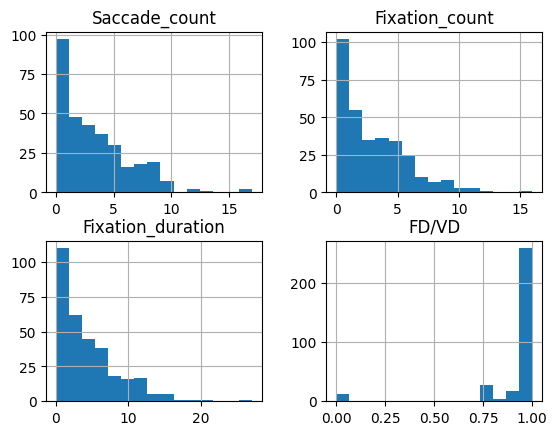

In [9]:
#histogram
TG_ALL_AOI_FINAL_DATA["black"][["Saccade_count","Fixation_count","Fixation_duration",	"FD/VD"]].hist(bins=15)
plt.show()

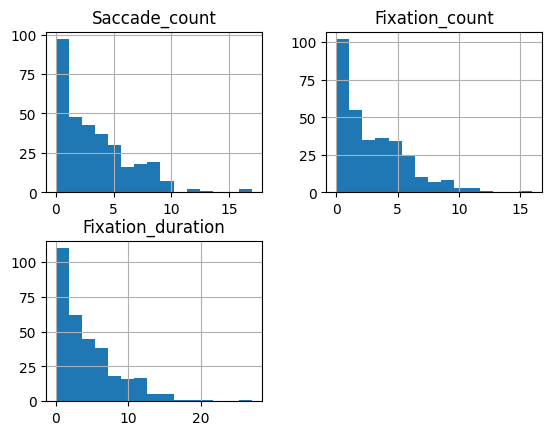

In [10]:
TG_ALL_AOI_FINAL_DATA["black"][["Saccade_count","Fixation_count","Fixation_duration"]].hist(bins=15)
plt.show()

### Untrained Group Analysis

In [11]:
#main analysis loop for Untrained_group
untrained_group_results = run_full_analysis("UTG",ALL_AOI_RECTS,MAX_ALLOWABLE_DISPLACEMENT, MIN_SACCADE_TIME, MIN_FIXATION_DURATION,NUMBER_OF_PARTICIPANTS,NUMBER_OF_IMAGES)
#aggregating results as dataframes
UTG_ALL_AOI_FINAL_DATA = aggregrate_results_into_dataframe(untrained_group_results,"UTG",NUMBER_OF_IMAGES)
print("Here are the dictionary keys for UTG_ALL_AOI_FINAL_DATA: {} ".format(UTG_ALL_AOI_FINAL_DATA.keys()))

Participant 1 in the UTG group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/UTG/001-UTG/IMG-1-0.csv'

Participant 1 in the UTG group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/UTG/001-UTG/IMG-1-1.csv'

Participant 1 in the UTG group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/UTG/001-UTG/IMG-1-2.csv'

Participant 1 in the UTG group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/UTG/001-UTG/IMG-1-3.csv'

Skipping empty image 4 in participant 1 in the UTG group
Participant 1 in the UTG group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/UTG/001-UTG/IM

#### Brief Visualization

In [12]:
UTG_ALL_AOI_FINAL_DATA["black"]

,Participant_id,image_id,Saccade_count,Fixation_count,Fixation_duration,Visitation_duration,Saccade_length,Saccade_duration,SC/FC,FD/VD
0,1.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.500000,0.991474
1,2.0,0.0,7,6,8.131583,8.249770,836.256897,0.118187,1.166667,0.985674
2,3.0,0.0,2,1,0.644120,0.677670,598.227139,0.033550,2.000000,0.950492
3,4.0,0.0,1,1,0.496954,0.513584,97.590983,0.016630,1.000000,0.967620
4,5.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.600000,0.990246
...,...,...,...,...,...,...,...,...,...,...
315,16.0,18.0,3,2,1.142600,1.192300,368.555535,0.049700,1.500000,0.958316
316,17.0,18.0,0,0,0.000000,0.000000,0.000000,0.000000,0.200000,0.598613
317,18.0,18.0,1,4,7.239700,7.256500,108.853112,0.016800,0.250000,0.997685
318,19.0,18.0,4,1,3.230900,3.296800,763.031887,0.065900,4.000000,0.980011


In [13]:
UTG_ALL_AOI_FINAL_DATA["black"]

,Participant_id,image_id,Saccade_count,Fixation_count,Fixation_duration,Visitation_duration,Saccade_length,Saccade_duration,SC/FC,FD/VD
0,1.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.500000,0.991474
1,2.0,0.0,7,6,8.131583,8.249770,836.256897,0.118187,1.166667,0.985674
2,3.0,0.0,2,1,0.644120,0.677670,598.227139,0.033550,2.000000,0.950492
3,4.0,0.0,1,1,0.496954,0.513584,97.590983,0.016630,1.000000,0.967620
4,5.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.600000,0.990246
...,...,...,...,...,...,...,...,...,...,...
315,16.0,18.0,3,2,1.142600,1.192300,368.555535,0.049700,1.500000,0.958316
316,17.0,18.0,0,0,0.000000,0.000000,0.000000,0.000000,0.200000,0.598613
317,18.0,18.0,1,4,7.239700,7.256500,108.853112,0.016800,0.250000,0.997685
318,19.0,18.0,4,1,3.230900,3.296800,763.031887,0.065900,4.000000,0.980011


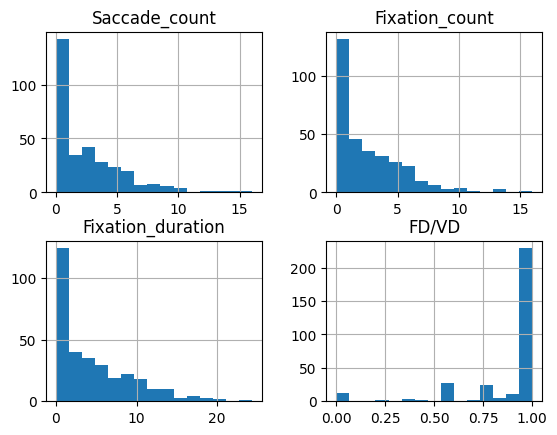

In [14]:
#histogram
UTG_ALL_AOI_FINAL_DATA["black"][["Saccade_count","Fixation_count","Fixation_duration", "FD/VD"]].hist(bins=15)
plt.show()

### Implicit Group analysis

In [15]:
#main analysis loop for Implicit_group
implicit_group_results = run_full_analysis("IL",ALL_AOI_RECTS,MAX_ALLOWABLE_DISPLACEMENT, MIN_SACCADE_TIME, MIN_FIXATION_DURATION,NUMBER_OF_PARTICIPANTS,NUMBER_OF_IMAGES)
#aggregating results as dataframes
IL_ALL_AOI_FINAL_DATA = aggregrate_results_into_dataframe(implicit_group_results,"IL",NUMBER_OF_IMAGES)
print("Here are the dictionary keys for IL_ALL_AOI_FINAL_DATA: {} ".format(IL_ALL_AOI_FINAL_DATA.keys()))

Participant 1 in the IL group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/IL/001-IL/IMG-1-1.csv'

Participant 1 in the IL group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/IL/001-IL/IMG-1-2.csv'

Participant 1 in the IL group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/IL/001-IL/IMG-1-3.csv'

Skipping empty image 4 in participant 1 in the IL group
Participant 1 in the IL group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/IL/001-IL/IMG-1-5.csv'

Participant 1 in the IL group is missing some of eye tracking data. Using placeholder results instead. Check the folder: [Errno 2] No such file or directory: 'Data/IL/001-IL/IMG-1-6.csv'

Part

#### Brief Visualization

In [16]:
IL_ALL_AOI_FINAL_DATA["black"]

,Participant_id,image_id,Saccade_count,Fixation_count,Fixation_duration,Visitation_duration,Saccade_length,Saccade_duration,SC/FC,FD/VD
0,1.0,0.0,7,3,3.578603,3.695102,1101.561688,0.116499,2.333333,0.968472
1,2.0,0.0,3,1,1.192720,1.242390,509.121019,0.049670,3.000000,0.960021
2,3.0,0.0,2,0,0.000000,0.032749,181.672169,0.032749,2.800000,0.000000
3,4.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000
4,5.0,0.0,6,3,4.156100,4.256180,1871.510319,0.100080,2.000000,0.976486
...,...,...,...,...,...,...,...,...,...,...
315,16.0,18.0,0,0,0.000000,0.000000,0.000000,0.000000,0.400000,0.784102
316,17.0,18.0,4,0,0.000000,0.066900,599.529936,0.066900,3.100000,0.000000
317,18.0,18.0,1,3,12.351900,12.368600,84.864598,0.016700,0.333333,0.998650
318,19.0,18.0,0,2,2.186500,2.186500,0.000000,0.000000,0.000000,1.000000


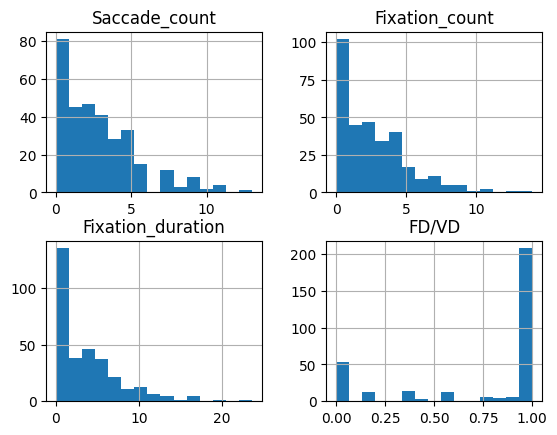

In [17]:
#history
IL_ALL_AOI_FINAL_DATA["black"][["Saccade_count","Fixation_count","Fixation_duration", "FD/VD"]].hist(bins=15)
plt.show()

### Saving the Joint results from all groups

In [18]:
TG = copy.deepcopy(TG_ALL_AOI_FINAL_DATA['black'])
UTG = copy.deepcopy(UTG_ALL_AOI_FINAL_DATA['black'])
IL = copy.deepcopy(IL_ALL_AOI_FINAL_DATA['black'])

TG_green = copy.deepcopy(TG_ALL_AOI_FINAL_DATA['green'])
UTG_green = copy.deepcopy(UTG_ALL_AOI_FINAL_DATA['green'])
IL_green = copy.deepcopy(IL_ALL_AOI_FINAL_DATA['green'])

TG_red = copy.deepcopy(TG_ALL_AOI_FINAL_DATA['red'])
UTG_red = copy.deepcopy(UTG_ALL_AOI_FINAL_DATA['red'])
IL_red = copy.deepcopy(IL_ALL_AOI_FINAL_DATA['red'])

TG_not = copy.deepcopy(TG_ALL_AOI_FINAL_DATA['Not_AOI'])
UTG_not = copy.deepcopy(UTG_ALL_AOI_FINAL_DATA['Not_AOI'])
IL_not = copy.deepcopy(IL_ALL_AOI_FINAL_DATA['Not_AOI'])


suffixes = ["_TG", "_UTG", "_IL"]
#joining the files
Final_result_black = join_dataframes([TG, UTG, IL], suffixes)
Final_result_green = join_dataframes([TG_green, UTG_green, IL_green], suffixes)
Final_result_red= join_dataframes([TG_red, UTG_red, IL_red], suffixes)
Final_result_not = join_dataframes([TG_not, UTG_not, IL_not], suffixes)

### Averages and a look at the final data for each AOI

In [19]:
#Black
final_result_black_avg = calculate_other_averages(Final_result_black,suffixes)
print(count_nans(Final_result_black)) # count null values
Final_result_black.head(10)

Average SC/FC value of the _TG group is 1.3583854730339104 

Average FD/VD value of the _TG group is 0.9226368512525378 

Average SC/FC value of the _UTG group is 1.2334684109293483 

Average FD/VD value of the _UTG group is 0.8763041048112965 

Average SC/FC value of the _IL group is 1.42756062513875 

Average FD/VD value of the _IL group is 0.7338930216149946 

{'column_nans': Participant_id             0
image_id                   0
Saccade_count_TG           0
Fixation_count_TG          0
Fixation_duration_TG       0
Visitation_duration_TG     0
Saccade_length_TG          0
Saccade_duration_TG        0
SC/FC_TG                   0
FD/VD_TG                   0
Saccade_count_UTG          0
Fixation_count_UTG         0
Fixation_duration_UTG      0
Visitation_duration_UTG    0
Saccade_length_UTG         0
Saccade_duration_UTG       0
SC/FC_UTG                  0
FD/VD_UTG                  0
Saccade_count_IL           0
Fixation_count_IL          0
Fixation_duration_IL       0
Visitatio

,Participant_id,image_id,Saccade_count_TG,Fixation_count_TG,Fixation_duration_TG,Visitation_duration_TG,Saccade_length_TG,Saccade_duration_TG,SC/FC_TG,FD/VD_TG,...,SC/FC_UTG,FD/VD_UTG,Saccade_count_IL,Fixation_count_IL,Fixation_duration_IL,Visitation_duration_IL,Saccade_length_IL,Saccade_duration_IL,SC/FC_IL,FD/VD_IL
0,1.0,0.0,4,7,7.587208,7.654100,724.968544,0.066892,0.571429,0.991261,...,0.500000,0.991474,7,3,3.578603,3.695102,1101.561688,0.116499,2.333333,0.968472
1,2.0,0.0,1,4,11.465712,11.482636,131.848398,0.016924,0.250000,0.998526,...,1.166667,0.985674,3,1,1.192720,1.242390,509.121019,0.049670,3.000000,0.960021
2,3.0,0.0,4,8,7.918032,7.984607,409.850032,0.066575,0.500000,0.991662,...,2.000000,0.950492,2,0,0.000000,0.032749,181.672169,0.032749,2.800000,0.000000
3,4.0,0.0,1,6,14.380012,14.397102,94.339811,0.017090,0.166667,0.998813,...,1.000000,0.967620,0,0,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000
4,5.0,0.0,3,4,3.330410,3.379650,391.268362,0.049240,0.750000,0.985430,...,0.600000,0.990246,6,3,4.156100,4.256180,1871.510319,0.100080,2.000000,0.976486
5,6.0,0.0,8,6,2.301586,2.435236,1707.894675,0.133650,1.333333,0.945118,...,0.500000,0.996712,4,3,3.842197,3.908147,918.233114,0.065950,1.333333,0.983125
6,7.0,0.0,5,5,6.428451,6.510995,639.169789,0.082544,1.000000,0.987322,...,1.000000,0.992746,0,0,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000
7,8.0,0.0,8,5,12.044079,12.176229,1288.629273,0.132150,1.600000,0.989147,...,1.000000,0.994760,2,3,5.070868,5.104978,254.209645,0.034110,0.666667,0.993318
8,9.0,0.0,3,2,2.352920,2.402870,352.246648,0.049950,1.500000,0.979212,...,0.600000,0.987983,2,1,0.696790,0.730662,274.986849,0.033872,2.000000,0.953642
9,10.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.600000,0.787842,...,1.000000,0.989576,5,9,8.912550,8.994990,742.764744,0.082440,0.555556,0.990835


In [20]:
#red
final_result_red_avg = calculate_other_averages(Final_result_red,suffixes)
print(count_nans(Final_result_red))
Final_result_red



Average SC/FC value of the _TG group is 1.2067877868659118 

Average FD/VD value of the _TG group is 0.7365313631840479 

Average SC/FC value of the _UTG group is 1.082072137931513 

Average FD/VD value of the _UTG group is 0.8095593518286318 

Average SC/FC value of the _IL group is 1.1454365946553446 

Average FD/VD value of the _IL group is 0.7594133132882828 

{'column_nans': Participant_id             0
image_id                   0
Saccade_count_TG           0
Fixation_count_TG          0
Fixation_duration_TG       0
Visitation_duration_TG     0
Saccade_length_TG          0
Saccade_duration_TG        0
SC/FC_TG                   0
FD/VD_TG                   0
Saccade_count_UTG          0
Fixation_count_UTG         0
Fixation_duration_UTG      0
Visitation_duration_UTG    0
Saccade_length_UTG         0
Saccade_duration_UTG       0
SC/FC_UTG                  0
FD/VD_UTG                  0
Saccade_count_IL           0
Fixation_count_IL          0
Fixation_duration_IL       0
Visitati

,Participant_id,image_id,Saccade_count_TG,Fixation_count_TG,Fixation_duration_TG,Visitation_duration_TG,Saccade_length_TG,Saccade_duration_TG,SC/FC_TG,FD/VD_TG,...,SC/FC_UTG,FD/VD_UTG,Saccade_count_IL,Fixation_count_IL,Fixation_duration_IL,Visitation_duration_IL,Saccade_length_IL,Saccade_duration_IL,SC/FC_IL,FD/VD_IL
0,1.0,0.0,2,0,0.0000,0.033267,339.839881,0.033267,1.800000,0.000000,...,0.600000,0.779511,1,2,2.83276,2.849270,143.561833,0.016510,0.500000,0.994206
1,2.0,0.0,0,0,0.0000,0.000000,0.000000,0.000000,0.200000,0.400000,...,0.500000,0.979400,2,0,0.00000,0.033353,798.193785,0.033353,2.200000,0.000000
2,3.0,0.0,0,0,0.0000,0.000000,0.000000,0.000000,0.200000,0.400000,...,2.200000,0.000000,4,0,0.00000,0.066750,670.271909,0.066750,3.000000,0.000000
3,4.0,0.0,1,0,0.0000,0.016590,238.270854,0.016590,1.800000,0.000000,...,1.000000,0.934464,0,0,0.00000,0.000000,0.000000,0.000000,0.400000,0.979991
4,5.0,0.0,3,0,0.0000,0.049525,481.689977,0.049525,2.300000,0.000000,...,0.700000,0.779511,1,1,0.59634,0.612910,96.332757,0.016570,1.000000,0.972965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,16.0,18.0,2,6,7.1053,7.138600,382.998889,0.033300,0.333333,0.995335,...,2.000000,0.954128,0,0,0.00000,0.000000,0.000000,0.000000,1.100000,0.589174
316,17.0,18.0,3,5,5.0900,5.140100,279.591528,0.050100,0.600000,0.990253,...,1.200000,0.395173,0,6,7.29330,7.293300,0.000000,0.000000,0.000000,1.000000
317,18.0,18.0,0,0,0.0000,0.000000,0.000000,0.000000,1.100000,0.773004,...,0.444444,0.994523,1,6,7.32130,7.337600,79.924965,0.016300,0.166667,0.997779
318,19.0,18.0,3,10,10.9696,11.018800,1054.270187,0.049200,0.300000,0.995535,...,0.000000,1.000000,2,0,0.00000,0.033700,246.357300,0.033700,1.600000,0.000000


In [21]:
#Green
final_result_green_avg = calculate_other_averages(Final_result_green,suffixes)
print(count_nans(Final_result_green))
Final_result_green.head(10)


Average SC/FC value of the _TG group is 1.1986886724386725 

Average FD/VD value of the _TG group is 0.6029390321072119 

Average SC/FC value of the _UTG group is 0.8354393262987013 

Average FD/VD value of the _UTG group is 0.6438281655052959 

Average SC/FC value of the _IL group is 1.039609375 

Average FD/VD value of the _IL group is 0.6833746271278331 

{'column_nans': Participant_id             0
image_id                   0
Saccade_count_TG           0
Fixation_count_TG          0
Fixation_duration_TG       0
Visitation_duration_TG     0
Saccade_length_TG          0
Saccade_duration_TG        0
SC/FC_TG                   0
FD/VD_TG                   0
Saccade_count_UTG          0
Fixation_count_UTG         0
Fixation_duration_UTG      0
Visitation_duration_UTG    0
Saccade_length_UTG         0
Saccade_duration_UTG       0
SC/FC_UTG                  0
FD/VD_UTG                  0
Saccade_count_IL           0
Fixation_count_IL          0
Fixation_duration_IL       0
Visitation_dur

,Participant_id,image_id,Saccade_count_TG,Fixation_count_TG,Fixation_duration_TG,Visitation_duration_TG,Saccade_length_TG,Saccade_duration_TG,SC/FC_TG,FD/VD_TG,...,SC/FC_UTG,FD/VD_UTG,Saccade_count_IL,Fixation_count_IL,Fixation_duration_IL,Visitation_duration_IL,Saccade_length_IL,Saccade_duration_IL,SC/FC_IL,FD/VD_IL
0,1.0,0.0,7,4,2.036520,2.153060,871.263475,0.116540,1.750000,0.945872,...,0.200000,0.791883,9,3,2.818130,2.966830,1327.232203,0.148700,3.000000,0.949879
1,2.0,0.0,3,0,0.000000,0.051441,311.878320,0.051441,2.800000,0.000000,...,3.000000,0.931549,10,3,1.953547,2.120220,1134.446963,0.166673,3.333333,0.921389
2,3.0,0.0,11,7,2.835782,3.017601,1506.840851,0.181819,1.571429,0.939747,...,2.400000,0.969725,1,2,2.898707,2.915938,115.420969,0.017231,0.500000,0.994091
3,4.0,0.0,4,1,0.315160,0.381390,489.893226,0.066230,4.000000,0.826346,...,1.666667,0.966961,0,0,0.000000,0.000000,0.000000,0.000000,0.300000,0.397252
4,5.0,0.0,5,3,3.710738,3.794133,528.433312,0.083395,1.666667,0.978020,...,0.200000,0.791883,7,2,1.075149,1.190074,800.421296,0.114925,3.500000,0.903430
5,6.0,0.0,6,11,7.569494,7.668446,760.867502,0.098952,0.545455,0.987096,...,2.500000,0.968235,5,0,0.000000,0.083340,549.609487,0.083340,3.200000,0.000000
6,7.0,0.0,7,2,2.054930,2.171689,896.688211,0.116759,3.500000,0.946236,...,1.500000,0.987420,0,0,0.000000,0.000000,0.000000,0.000000,0.700000,0.400000
7,8.0,0.0,1,1,0.446690,0.463890,93.861600,0.017200,1.000000,0.962922,...,4.000000,0.985893,6,5,4.486876,4.586684,795.779454,0.099808,1.200000,0.978240
8,9.0,0.0,7,7,5.186149,5.302927,1010.266763,0.116778,1.000000,0.977979,...,0.000000,0.800000,3,1,0.878150,0.927840,300.561556,0.049690,3.000000,0.946446
9,10.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.200000,0.792584,...,2.600000,0.963334,5,3,2.203000,2.285742,841.384853,0.082742,1.666667,0.963801


In [22]:
#not AOI
final_result_not_avg = calculate_other_averages(Final_result_not,suffixes)
print(count_nans(Final_result_not))
Final_result_not.head(10)

Average SC/FC value of the _TG group is 2.263219104552056 

Average FD/VD value of the _TG group is 0.9649252927238365 

Average SC/FC value of the _UTG group is 2.355798492364275 

Average FD/VD value of the _UTG group is 0.9716444850817766 

Average SC/FC value of the _IL group is 2.331281727090602 

Average FD/VD value of the _IL group is 0.9715982353962354 

{'column_nans': Participant_id             0
image_id                   0
Saccade_count_TG           0
Fixation_count_TG          0
Fixation_duration_TG       0
Visitation_duration_TG     0
Saccade_length_TG          0
Saccade_duration_TG        0
SC/FC_TG                   0
FD/VD_TG                   0
Saccade_count_UTG          0
Fixation_count_UTG         0
Fixation_duration_UTG      0
Visitation_duration_UTG    0
Saccade_length_UTG         0
Saccade_duration_UTG       0
SC/FC_UTG                  0
FD/VD_UTG                  0
Saccade_count_IL           0
Fixation_count_IL          0
Fixation_duration_IL       0
Visitation

,Participant_id,image_id,Saccade_count_TG,Fixation_count_TG,Fixation_duration_TG,Visitation_duration_TG,Saccade_length_TG,Saccade_duration_TG,SC/FC_TG,FD/VD_TG,...,SC/FC_UTG,FD/VD_UTG,Saccade_count_IL,Fixation_count_IL,Fixation_duration_IL,Visitation_duration_IL,Saccade_length_IL,Saccade_duration_IL,SC/FC_IL,FD/VD_IL
0,1.0,0.0,87,29,28.243954,29.690905,13244.204101,1.446951,3.000000,0.951266,...,3.032830,0.973264,82,26,27.377574,28.739470,15744.661379,1.361896,3.153846,0.952612
1,2.0,0.0,24,12,27.762004,28.161619,3453.782677,0.399615,2.000000,0.985810,...,2.037037,0.966898,53,28,35.436428,36.312794,8060.318407,0.876366,1.892857,0.975866
2,3.0,0.0,85,32,27.093319,28.500038,11659.106121,1.406719,2.656250,0.950642,...,2.575000,0.944450,69,30,35.528888,36.673534,11634.590077,1.144646,2.300000,0.968788
3,4.0,0.0,84,23,23.673561,25.058435,14751.875210,1.384874,3.652174,0.944734,...,2.142857,0.972798,0,0,0.000000,0.000000,0.000000,0.000000,2.355873,0.970655
4,5.0,0.0,47,29,31.410941,32.191252,6682.460884,0.780311,1.620690,0.975760,...,2.461548,0.977817,73,28,32.238459,33.451022,11744.393368,1.212563,2.607143,0.963751
5,6.0,0.0,128,42,27.617243,29.737134,22520.784109,2.119891,3.047619,0.928712,...,2.800000,0.958035,56,24,34.374678,35.301975,11687.226693,0.927297,2.333333,0.973732
6,7.0,0.0,54,26,28.923071,29.817531,7706.132732,0.894460,2.076923,0.970002,...,1.857143,0.977424,0,0,0.000000,0.000000,0.000000,0.000000,2.219206,0.973168
7,8.0,0.0,67,33,25.153328,26.265912,9624.342191,1.112584,2.030303,0.957642,...,2.500000,0.983114,42,18,24.059745,24.758095,5605.947648,0.698350,2.333333,0.971793
8,9.0,0.0,123,43,27.406108,29.435150,20277.920974,2.029042,2.860465,0.931067,...,2.563333,0.975798,55,20,37.059547,37.972419,10056.487810,0.912872,2.750000,0.975960
9,10.0,0.0,0,0,0.000000,0.000000,0.000000,0.000000,1.782222,0.975840,...,2.230769,0.968172,91,41,26.134674,27.631831,14600.715454,1.497157,2.219512,0.945818


### Dropping the Fixation columns since we have more accurate results from the ogama software

### Saving the files to google drive

In [23]:

Final_result_black.to_csv("Originalresults/final_data/Final_result_black_AOI.csv",index=False)
Final_result_green.to_csv("Originalresults/final_data/Final_result_green_AOI.csv",index=False)
Final_result_red.to_csv("Originalresults/final_data/Final_result_red_AOI.csv",index=False)
Final_result_not.to_csv("Originalresults/final_data/Final_result_Not_AOI.csv",index=False)


# Step three: Running ANOVA analysis

Null Hypothesis: There is no statistical difference between the FD/VD and SC/FC metrics computed for the three groups in each AOI (p-value threshold: 0.01)

Alternative Hypothesis: There is a  statistical difference between the FD/VD and SC/FC metrics computed for the three groups in each AOI

###### Black AOI

In [24]:

FD_VD_anova_black = perform_anova(Final_result_black["FD/VD_TG"],Final_result_black["FD/VD_UTG"],Final_result_black["FD/VD_IL"])
SC_FC_anova_black = perform_anova(Final_result_black["SC/FC_TG"],Final_result_black["SC/FC_UTG"],Final_result_black["SC/FC_IL"])
print( "The anova results for FD/VD for the various groups based on their interaction with the black AOI:\n F-statistic: {} \t p-value: {}\n".format(FD_VD_anova_black['F-statistic'],FD_VD_anova_black['p-value']))
print( "The anova results for SC/FC for the various groups based on their interaction with the black AOI:\n F-statistic: {} \t p-value: {}\n".format(SC_FC_anova_black['F-statistic'],SC_FC_anova_black['p-value']))

The anova results for FD/VD for the various groups based on their interaction with the black AOI:
 F-statistic: 38.44956378703519 	 p-value: 8.68077354506116e-17

The anova results for SC/FC for the various groups based on their interaction with the black AOI:
 F-statistic: 1.8478135416927237 	 p-value: 0.15814311437642872



###### Green AOI

In [25]:
FD_VD_anova_green = perform_anova(Final_result_green["FD/VD_TG"], Final_result_green["FD/VD_UTG"], Final_result_green["FD/VD_IL"])
SC_FC_anova_green = perform_anova(Final_result_green["SC/FC_TG"],Final_result_green["SC/FC_UTG"], Final_result_green["SC/FC_IL"])
print( "The anova results for FD/VD for the various groups based on their interaction with the green AOI:\n F-statistic: {} \t p-value: {}\n".format(FD_VD_anova_green['F-statistic'],FD_VD_anova_green['p-value']))
print( "The anova results for SC/FC for the various groups based on their interaction with the green AOI:\n F-statistic: {} \t p-value: {}\n".format(SC_FC_anova_green['F-statistic'],SC_FC_anova_green['p-value']))

The anova results for FD/VD for the various groups based on their interaction with the green AOI:
 F-statistic: 3.9276723574976207 	 p-value: 0.020007656198774093

The anova results for SC/FC for the various groups based on their interaction with the green AOI:
 F-statistic: 4.815860606308771 	 p-value: 0.008297613020165606



###### Red AOI

In [26]:
FD_VD_anova_red = perform_anova(Final_result_red["FD/VD_TG"],Final_result_red["FD/VD_UTG"],Final_result_red["FD/VD_IL"])
SC_FC_anova_red = perform_anova(Final_result_red["SC/FC_TG"],Final_result_red["SC/FC_UTG"],Final_result_red["SC/FC_IL"])
print( "The anova results for FD/VD for the various groups based on their interaction with the red AOI:\n F-statistic: {} \t p-value: {}\n".format(FD_VD_anova_red['F-statistic'],FD_VD_anova_red['p-value']))
print( "The anova results for SC/FC for the various groups based on their interaction with the red AOI:\n F-statistic: {} \t p-value: {}\n".format(SC_FC_anova_red['F-statistic'],SC_FC_anova_red['p-value']))

The anova results for FD/VD for the various groups based on their interaction with the red AOI:
 F-statistic: 5.050751848151827 	 p-value: 0.006576308967300697

The anova results for SC/FC for the various groups based on their interaction with the red AOI:
 F-statistic: 0.9522148554073387 	 p-value: 0.38625069290124703



###### Non AOI

In [27]:
FD_VD_anova_not = perform_anova(Final_result_not["FD/VD_TG"],Final_result_not["FD/VD_UTG"],Final_result_not["FD/VD_IL"])
SC_FC_anova_not = perform_anova(Final_result_not["SC/FC_TG"],Final_result_not["SC/FC_UTG"],Final_result_not["SC/FC_IL"])
print( "The anova results for FD/VD for the various groups based on their interaction with non AOIs:\n F-statistic: {} \t p-value: {}\n".format(FD_VD_anova_not['F-statistic'],FD_VD_anova_not['p-value']))
print( "The anova results for SC/FC for the various groups based on their interaction with non AOIs:\n F-statistic: {} \t p-value: {}\n".format(SC_FC_anova_not['F-statistic'],SC_FC_anova_not['p-value']))

The anova results for FD/VD for the various groups based on their interaction with non AOIs:
 F-statistic: 26.644795231677904 	 p-value: 5.482889368054386e-12

The anova results for SC/FC for the various groups based on their interaction with non AOIs:
 F-statistic: 2.3563682152926226 	 p-value: 0.09531336491012178



##### Tabulating pairs of anova results for each group

In [28]:
metrics = ["FD/VD","SC/FC","Saccade_count","Fixation_count","Fixation_duration", "Visitation_duration","Saccade_duration","Saccade_length"]

anova_table_black = perform_anova_on_dataframe(Final_result_black, metrics, suffixes)
anova_table_green = perform_anova_on_dataframe(Final_result_green, metrics, suffixes)
anova_table_red = perform_anova_on_dataframe(Final_result_red, metrics, suffixes)
anova_table_non = perform_anova_on_dataframe(Final_result_not, metrics, suffixes)

anova_table_black.to_csv("Originalresults/anova_table_black_AOI.csv",index=False)
anova_table_green.to_csv("Originalresults/anova_table_green_AOI.csv",index=False)
anova_table_red.to_csv("Originalresults/anova_table_red_AOI.csv",index=False)
anova_table_non.to_csv("Originalresults/anova_table_non_AOI.csv",index=False)




In [29]:
anova_table_black

,Metric,Group1,Group2,F-statistic,p-value
0,FD/VD,FD/VD_TG,FD/VD_UTG,7.595872,6.017345e-03
1,FD/VD,FD/VD_TG,FD/VD_IL,60.561436,2.884123e-14
2,FD/VD,FD/VD_UTG,FD/VD_IL,31.740078,2.645395e-08
3,SC/FC,SC/FC_TG,SC/FC_UTG,1.341467,2.472088e-01
4,SC/FC,SC/FC_TG,SC/FC_IL,0.507484,4.764903e-01
5,SC/FC,SC/FC_UTG,SC/FC_IL,3.636238,5.698343e-02
6,Saccade_count,Saccade_count_TG,Saccade_count_UTG,9.741892,1.882519e-03
7,Saccade_count,Saccade_count_TG,Saccade_count_IL,7.382766,6.763851e-03
8,Saccade_count,Saccade_count_UTG,Saccade_count_IL,0.268202,6.047199e-01
9,Fixation_count,Fixation_count_TG,Fixation_count_UTG,3.804927,5.153946e-02


In [30]:
anova_table_red

,Metric,Group1,Group2,F-statistic,p-value
0,FD/VD,FD/VD_TG,FD/VD_UTG,9.833012,0.001793
1,FD/VD,FD/VD_TG,FD/VD_IL,0.833854,0.361506
2,FD/VD,FD/VD_UTG,FD/VD_IL,5.161788,0.023421
3,SC/FC,SC/FC_TG,SC/FC_UTG,2.026078,0.155108
4,SC/FC,SC/FC_TG,SC/FC_IL,0.390703,0.532153
5,SC/FC,SC/FC_UTG,SC/FC_IL,0.558173,0.455273
6,Saccade_count,Saccade_count_TG,Saccade_count_UTG,4.355302,0.037290
7,Saccade_count,Saccade_count_TG,Saccade_count_IL,5.503453,0.019284
8,Saccade_count,Saccade_count_UTG,Saccade_count_IL,0.041772,0.838121
9,Fixation_count,Fixation_count_TG,Fixation_count_UTG,1.837186,0.175761


In [31]:
anova_table_green

,Metric,Group1,Group2,F-statistic,p-value
0,FD/VD,FD/VD_TG,FD/VD_UTG,1.957853,0.162229
1,FD/VD,FD/VD_TG,FD/VD_IL,7.659336,0.005812
2,FD/VD,FD/VD_UTG,FD/VD_IL,2.024620,0.155256
3,SC/FC,SC/FC_TG,SC/FC_UTG,9.643202,0.001985
4,SC/FC,SC/FC_TG,SC/FC_IL,1.808933,0.179114
5,SC/FC,SC/FC_UTG,SC/FC_IL,3.056813,0.080880
6,Saccade_count,Saccade_count_TG,Saccade_count_UTG,5.324446,0.021347
7,Saccade_count,Saccade_count_TG,Saccade_count_IL,4.438638,0.035524
8,Saccade_count,Saccade_count_UTG,Saccade_count_IL,0.099779,0.752198
9,Fixation_count,Fixation_count_TG,Fixation_count_UTG,1.465027,0.226580


# Posthoc

In [32]:
metrics = ["FD/VD","SC/FC","Saccade_count","Fixation_count","Fixation_duration", "Visitation_duration","Saccade_duration","Saccade_length"]
posthoc_black= pairwise_anova_with_tukey(Final_result_black, metrics)
posthoc_green= pairwise_anova_with_tukey(Final_result_green, metrics)
posthoc_red= pairwise_anova_with_tukey(Final_result_red, metrics)
posthoc_non= pairwise_anova_with_tukey(Final_result_not, metrics)

In [33]:
#saving
posthoc_black["anova"].to_csv("Originalresults/tukey_results/posthoc_anova_black_AOI.csv",index=False)
posthoc_black["tukey"].to_csv("Originalresults/tukey_results/posthoc_tukey_black_AOI.csv",index=False)
posthoc_green["anova"].to_csv("tukey_results/posthoc_anova_green_AOI.csv",index=False)
posthoc_green["tukey"].to_csv("Originalresults/tukey_results/posthoc_tukey_green_AOI.csv",index=False)
posthoc_red["anova"].to_csv("Originalresults/tukey_results/posthoc_anova_red_AOI.csv",index=False)
posthoc_red["tukey"].to_csv("Originalresults/tukey_results/posthoc_tukey_red_AOI.csv",index=False)
posthoc_non["anova"].to_csv("Originalresults/tukey_results/posthoc_anova_non_AOI.csv",index=False)
posthoc_non["tukey"].to_csv("Originalresults/tukey_results/posthoc_tukey_non_AOI.csv",index=False)